# Electronic Band Structure from GW
**by <span style="color:darkgreen">Dmitrii Nabok</span>, <span style="color:darkgreen">Keith Gilmore</span> & <span style="color:darkgreen">Sven Lubeck</span> for [<span style="color:darkgoldenrod">exciting *neon*</span>](https://www.exciting-code.org/neon)**

<font size="2">(Jupyter notebook by <span style="color:darkgreen">Megha Arya</span> and <span style="color:darkgreen">Mara Voiculescu</span>)</font>
<hr style="border:2px solid #DDD"> </hr>

**<span style="color:firebrick">Purpose</span>**:  In this tutorial you will learn how to perform a basic **G<sub>0</sub>W<sub>0</sub>** calculation. As an example, the electronic band structure of bulk Si is calculated. Notice that **self-consistent GW** is not yet implemented in **exciting**.
<hr style="border:2px solid #DDD"> </hr>

<div class="alert alert-block alert-warning">
    
**Table of Contents**

[0. Before Starting](#0)
    
[1. Theoretical Background: G<sub>0</sub>W<sub>0</sub> Approximation](#1)    
    
[2. Ground-State Calculation](#2)
    
[3. GW "Single-Shot" Run](#3)
        
[4. Quasiparticle Band Structure](#4)
    
  - [Band Structure Plot](#4) 
  - [Density of States](#5)    
  - [Converging Results](#6)

[Exercise](#6)

[Literature](#7)
    
</div>

<a id='0'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">0. Before Starting</span>

**<span style="color:firebrick">Read the following paragraphs before starting with the rest of this tutorial!</span>**

Before running any Jupyter tutorials, please refer to the **`00_before_starting.md`** document on how to correctly set up the environment. This only needs to be done once. After which, the **venv** can be (re)activated from **`exciting`**'s root directory:

<div style="background-color: rgb(224, 224, 224);">

```bash
source tools/excitingjupyter/venv/excitingvenv/bin/activate
```

</div>


**<span style="color:firebrick">Important note:</span>** All input parameters are in **atomic units**!

<a id='1'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">1. Theoretical Background: G<sub>0</sub>W<sub>0</sub> Approximation</span>

The quasiparticle energies in the **G<sub>0</sub>W<sub>0</sub>** approximation are given as a solution of the linearized quasi-particle (**QP**) equation [**<span style="color:firebrick">Hybertsen1986</span>**](#7) as

\begin{equation}
\tag{1}
\epsilon_{n\mathbf k}^{QP} = \epsilon_{n\mathbf k} + Z_{n\mathbf k}  \Big[ Re \sum_{n\mathbf k} (\epsilon_{n\mathbf k})- V_{n\mathbf k}^{xc}\Big],
\end{equation}

where $\epsilon_{n\mathbf k}$ are the Kohn-Sham (**KS**) eigenvalues, $\sum_{n\mathbf k}$ and $V_{n\mathbf k}^{xc}$ are, respectively, the diagonal matrix elements of the self-energy and the exchange-correlation (**xc**) potential that is employed in the single-particle **KS** Hamiltonian. The **QP** renormalization factor $Z_{n\mathbf k}$ accounts for the energy-dependence of the self-energy. The self-energy $\sum (\mathbf r , \mathbf r^{\prime};\omega)$ is given by [**<span style="color:firebrick">Hedin1965</span>**](#7)

\begin{equation}
\tag{2}
\sum (\mathbf r , \mathbf r^{\prime};\omega) = \frac{i}{2\pi} \int G_{0}(\mathbf r , \mathbf r^{\prime};\omega + \omega^{\prime}) \; W_{0}(\mathbf r , \mathbf r^{\prime}; \omega^{\prime}) \; e^{i \omega^{\prime}\eta} \; d \omega^{\prime} ,
\end{equation}

where $G_{0}$ is the noninteracting single-particle Green function obtained from the Kohn-Sham states and $W_{0}$ is the dynamically screened Coulomb potential

\begin{equation}
\tag{3}
W_{0}(\mathbf r , \mathbf r^{\prime}; \omega) = \int \epsilon^{-1} (\mathbf r ,\mathbf r^{\prime\prime}; \omega) \; \nu_{C}(\mathbf r^{\prime\prime}, \mathbf r^{\prime}) \; d\mathbf r^{\prime\prime} .
\end{equation}

Here, $\nu_{C} ( \mathbf r, \mathbf r^{\prime}) = 1/|\mathbf r - \mathbf r^{\prime} | $  is the Coulomb potential and $\epsilon (\mathbf r ,\mathbf r^{\prime}; \omega) $ is the dielectric function calculated in the random-phase approximation (**RPA**).

<a id='2'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">2. Ground-State Calculation</span>

As a first step, create a new directory named **run_Si_GW** and move inside it.

In [1]:
%%bash
mkdir -p run_Si_GW

Below is the input file (**input.xml**) for bulk Si, which we consider in this tutorial.

<span class="SILICON_GS"></span>
```xml
<input>
 
   <title>Silicon: Ground-State Calculation</title>
 
   <structure speciespath="$EXCITINGROOT/species">
      <crystal>
         <basevect>5.13 5.13 0.00</basevect>
         <basevect>5.13 0.00 5.13</basevect>
         <basevect>0.00 5.13 5.13</basevect>
      </crystal>
      <species speciesfile="Si.xml" rmt="2.1">
         <atom coord="0.00 0.00 0.00"></atom>
         <atom coord="0.25 0.25 0.25"></atom>
      </species>
   </structure>
 
   <groundstate
      do="fromscratch"
      rgkmax="7.0"
      ngridk="3 3 3"
      xctype="LDA_PW"
      >
   </groundstate>
 
</input>

```

The next step is writing the complete input as a string and saving it in your working directory as **input.xml**.

In [3]:
import os
from excitingjupyter.utilities import get_input_xml_from_notebook   

# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("01_tutorial_electronic_band_structure_from_gw", "SILICON_GS")

# Write out the input as an XML file:
with open('./run_Si_GW/input.xml', "w") as fid:
    fid.write(input_str)

**<span style="color:firebrick">N.B.</span>**: Do not forget to replace in the **input.xml** the string **"\$EXCITINGROOT"** by the actual value of the environment variable **$EXCITINGROOT** using the command

In [3]:
%%bash
cd run_Si_GW
python3 -m excitingscripts.setup.excitingroot
cd ..

In order to run **`exciting`**, simply execute the **exciting_smp** binary in the running directory.

In [5]:
%%bash
cd run_Si_GW
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml


   Elapsed time = 0m10s


After the run, one can inspect the **INFO.OUT** file for checking the convergence behaviour of the **SCF** cycle and for other information related to the ground-state calculation. Please note that the quality of the groundstate calculations (the starting point) plays an important role when calculating **G<sub>0</sub>W<sub>0</sub> QP** corrections. Therefore one should always check the convergence of results with respect to the <code><span style="color:green">groundstate</span></code> parameters (such as <code><span style="color:mediumblue">rgkmax</span></code>, <code><span style="color:mediumblue">ngridk</span></code>, etc.) in production calculations.

<a id='3'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">3. GW "Single-Shot" Run</span>

Using the data from the previous run as an input, one performs a **G<sub>0</sub>W<sub>0</sub>** calculation to obtain the **QP** energies.

Disable the execution of the ground-state run by changing the attribute <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"fromscratch"</span></code> to <code><span style="color:mediumblue">do</span>=<span style="color:firebrick">"skip"</span></code> in the <code><span style="color:green">groundstate</span></code> element of the **input.xml** file.

To initialize **G<sub>0</sub>W<sub>0</sub>** calculations, a new block, corresponding to the element <code><span style="color:green">gw</span></code>, must be added to the input file inside the <code><span style="color:green">input</span></code> element. Now the file **input.xml** will look like the following.

<span class="SILICON_GW"></span>
```xml
<input>
 
   <title>Silicon: GW Single-Shot Run</title>
 
   <structure speciespath="$EXCITINGROOT/species">
      <crystal>
         <basevect>5.13 5.13 0.00</basevect>
         <basevect>5.13 0.00 5.13</basevect>
         <basevect>0.00 5.13 5.13</basevect>
      </crystal>
      <species speciesfile="Si.xml" rmt="2.1">
         <atom coord="0.00 0.00 0.00"></atom>
         <atom coord="0.25 0.25 0.25"></atom>
      </species>
   </structure>
 
   <groundstate
      do="skip"
      rgkmax="7.0"
      ngridk="3 3 3"
      xctype="LDA_PW"
      >
   </groundstate>
   
   <gw
      taskname="g0w0"
      ngridq="3 3 3"
      nempty="22"
      ibgw="1" 
      nbgw="10"
      coreflag="xal"
      >
      <mixbasis
         lmaxmb="3"
         epsmb="1.d-4"
         gmb="1.0"
      ></mixbasis>
      <freqgrid
         nomeg="12"
      ></freqgrid>
   </gw>
 
</input>

```

Let us look closer at the <code><span style="color:green">gw</span></code> element. Attributes and elements used in this example are :

Parameter | Description 
:--- | :--- 
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">taskname</span></code>|Specifies the task name.
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">ngridq</span></code>|Specifies the number of both the **k** and the **q**-points used specifically in **GW** calculations. Notice that these values are independent from the one specified by <code><span style="color:green">groundstate</span></code>/<code><span style="color:mediumblue">ngridk</span></code>.
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">nempty</span></code>|The number of empty states used as an input in **GW** calculations. Note that this value is independent from the one specified inside the <code><span style="color:green">groundstate</span></code> element.
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">ibgw</span></code>, <code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">nbgw</span></code>|Give the range of resulting QP states to be calculated. <code><span style="color:mediumblue">ibgw</span></code> (<code><span style="color:mediumblue">nbgw</span></code>) is the lowest (highest) band index for which the **GW** correction is calculated. Notice that the numbering of the band indexes is such that the index **<span style="color:firebrick">1</span>** is the one for the lowest occupied valence band. Furthermore, <code><span style="color:mediumblue">nbgw</span></code> must be chosen to be larger than the number of occupied bands.
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">coreflag</span></code>|Specifies the treatment of core electrons.
<code><span style="color:green">gw</span></code>/<code><span style="color:green">mixbasis</span></code>|Specifies the parameters for the mixed product basis.
<code><span style="color:green">gw</span></code>/<code><span style="color:green">freqgrid</span></code>|Specifies the frequency grid for dynamical quantities.

For all available parameters and options and their description, one should check the **GW Section** of **[Input Reference](https://www.exciting-code.org/home/about/input-reference)**. It is interesting to notice that the computational setup given for the mixed-product basis and the frequency grid is rather universal and could be applied for most materials without modification.

In [4]:
# Extract input file content from this notebook:
input_str = get_input_xml_from_notebook("01_tutorial_electronic_band_structure_from_gw", "SILICON_GW")

# Write out the input as an XML file:
with open('./run_Si_GW/input.xml', "w") as fid:
    fid.write(input_str)

In [5]:
%%bash
cd run_Si_GW
python3 -m excitingscripts.setup.excitingroot
cd ..

We are now ready to run the calculation with the usual command. 

In [6]:
%%bash
cd run_Si_GW
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml
 ### Using specified input file: input.xml


   Elapsed time = 1m33s


Once the calculation has finished, the main output of the **G<sub>0</sub>W<sub>0</sub>** run will be stored in **GW_INFO.OUT** and **EVALQP.DAT**. The former file contains information on the **GW** program work-flow. In particular, energy band-gap values for **KS** and **QP** spectra can be found at the end of this file.

The text file **EVALQP.DAT** contains all important quantities that are calculated during the **G<sub>0</sub>W<sub>0</sub>** run. Below, we describe the structure of this file. The line **<span style="color:mediumblue">"k-point # 1:"</span>** starts the block of data and contains the lattice coordinates of the irreducible k-point and the corresponding Brillouin-zone-integration weight. Then, for each electronic state (within the range determined by the <code><span style="color:mediumblue">ibgw</span></code> and <code><span style="color:mediumblue">nbgw</span></code> input attributes) one can find the following quantities:

* the starting **KS** eigenenergies (**<span style="color:mediumblue">E_KS</span>**);
* the quasiparticle energies as obtained by considering the exchange part of the self-energy only (**<span style="color:mediumblue">E_HF</span>**);
* the G<sub>0</sub>W<sub>0</sub> quasiparticle energies (**<span style="color:mediumblue">E_GW</span>**);
* the diagonal matrix elements of the exchange self-energy (**<span style="color:mediumblue">Sx</span>**);
* the diagonal matrix elements of the correlation self-energy (**<span style="color:mediumblue">Sc</span>**);
* the diagonal matrix elements of the underlying exchange-correlation potential (**<span style="color:mediumblue">Vxc</span>**);
* the energy difference **E_HF−E_KS** (**<span style="color:mediumblue">DE_HF</span>**);
* the energy difference **E_GW−E_KS** (**<span style="color:mediumblue">DE_GW</span>**);
* the linearization prefactor $Z_{n\mathbf k}$ (**<span style="color:mediumblue">Znk</span>**).

It is **<span style="color:firebrick">important to note</span>** that the zero of the **E_HF** and **E_GW** quasiparticle energies listed in **EVALQP.DAT** is the **KS** Fermi energy (that can be found, *e.g.*, in **GW_INFO.OUT**). Therefore, in order to obtain absolute **QP** eigenenergies one has to add to the data listed in **EVALQP.DAT** the corresponding **KS** Fermi energy.

<a id='4'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">4. Quasiparticle Band Structure</span>

**i) Band Structure Plot**

Now, we will visualize the results to compare the Kohn-Sham (**KS**) and quasiparticle (**QP**, **G<sub>0</sub>W<sub>0</sub>**) band structures. To calculate them, one should introduce the following changes into the **input.xml** file.

* After the <code><span style="color:green">groundstate</span></code> block, add the new element block <code><span style="color:green">properties</span></code> as indicated below.

```xml
...  
   <properties>
      <bandstructure>
         <plot1d>
            <path steps="100">
               <point coord="1.0     0.0     0.0" label="Gamma"/>
               <point coord="0.625   0.375   0.0" label="K"/>
               <point coord="0.5     0.5     0.0" label="X"/>
               <point coord="0.0     0.0     0.0" label="Gamma"/>
               <point coord="0.5     0.0     0.0" label="L"/> 
            </path>
         </plot1d>
      </bandstructure>
      <dos
         inttype="trilin"
         winddos="-0.5 0.5"
         nwdos="200"
      ></dos>
   </properties>
...
```

* In the <code><span style="color:green">gw</span></code> element replace <code><span style="color:mediumblue">taskname</span>=<span style="color:firebrick">"g0w0"</span></code> by <code><span style="color:mediumblue">taskname</span>=<span style="color:firebrick">"band"</span></code> to calculate the **QP** band structure on the basis of results obtained from the previous **G<sub>0</sub>W<sub>0</sub>** run. In this case, Fourier interpolation is used to evaluate the band energies for the **k**-point path specified in the <code><span style="color:green">properties</span></code> element.
    
```xml
...
   <gw
      taskname="band"
      ... >
   </gw>
...
```

In [18]:
# The following lines modify the input.xml using Python
from excitingtools import ExcitingInputXML, ExcitingPropertiesInput

parsed_input = ExcitingInputXML.from_xml('./run_Si_GW/input.xml')

properties = {
        "bandstructure": {"plot1d": {"path": {
            "steps": 100,
            "point":
                [
                    {"coord": [1, 0, 0], "label": "Gamma"},
                    {"coord": [0.625, 0.375, 0], "label": "K"},
                    {"coord": [0.5, 0.5, 0], "label": "X"},
                    {"coord": [0, 0, 0], "label": "Gamma"},
                    {"coord": [0.5, 0, 0], "label": "L"}]}}},
        "dos": {"inttype": "trilin", "nwdos": 200, "winddos": [-0.5, 0.5]}}

parsed_input.properties = ExcitingPropertiesInput(**properties)
parsed_input.gw.taskname = "band"

parsed_input.write('./run_Si_GW/input.xml')

Finally, run **`exciting`** one more time.

In [19]:
%%bash
cd run_Si_GW
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml
 ### Using specified input file: input.xml
 
Info(bandstr):
 band structure plot written to BAND.OUT
 
 Fermi energy is at zero in plot
 
 Vertex location lines written to BANDLINES.OUT
 
 ### Using specified input file: input.xml
 
Info(dos):
 
   Total density of states written to TDOS.OUT
 
   Fermi energy is at zero in plot
 
   DOS units are states/Hartree/unit cell
 
 ### Using specified input file: input.xml


   Elapsed time = 0m3s


The output files **BAND.OUT** and **BAND-QP.OUT** can now be used to plot the electronic band structure. This can be easily done using the script **`excitingscripts.plot.band_structure`**, which is described in details in  [**The python script "plot.band_structure"**](https://www.exciting-code.org/the-python-script-plot.band_structure).

In [21]:
%%bash
cd run_Si_GW
python3 -m excitingscripts.plot.band_structure -a KS GW  -e -15 10
cd ..

The script produces a file **PLOT.png** which you can visualize on the screen with standard tools. The result should look like the following.

<div>
<img src=" 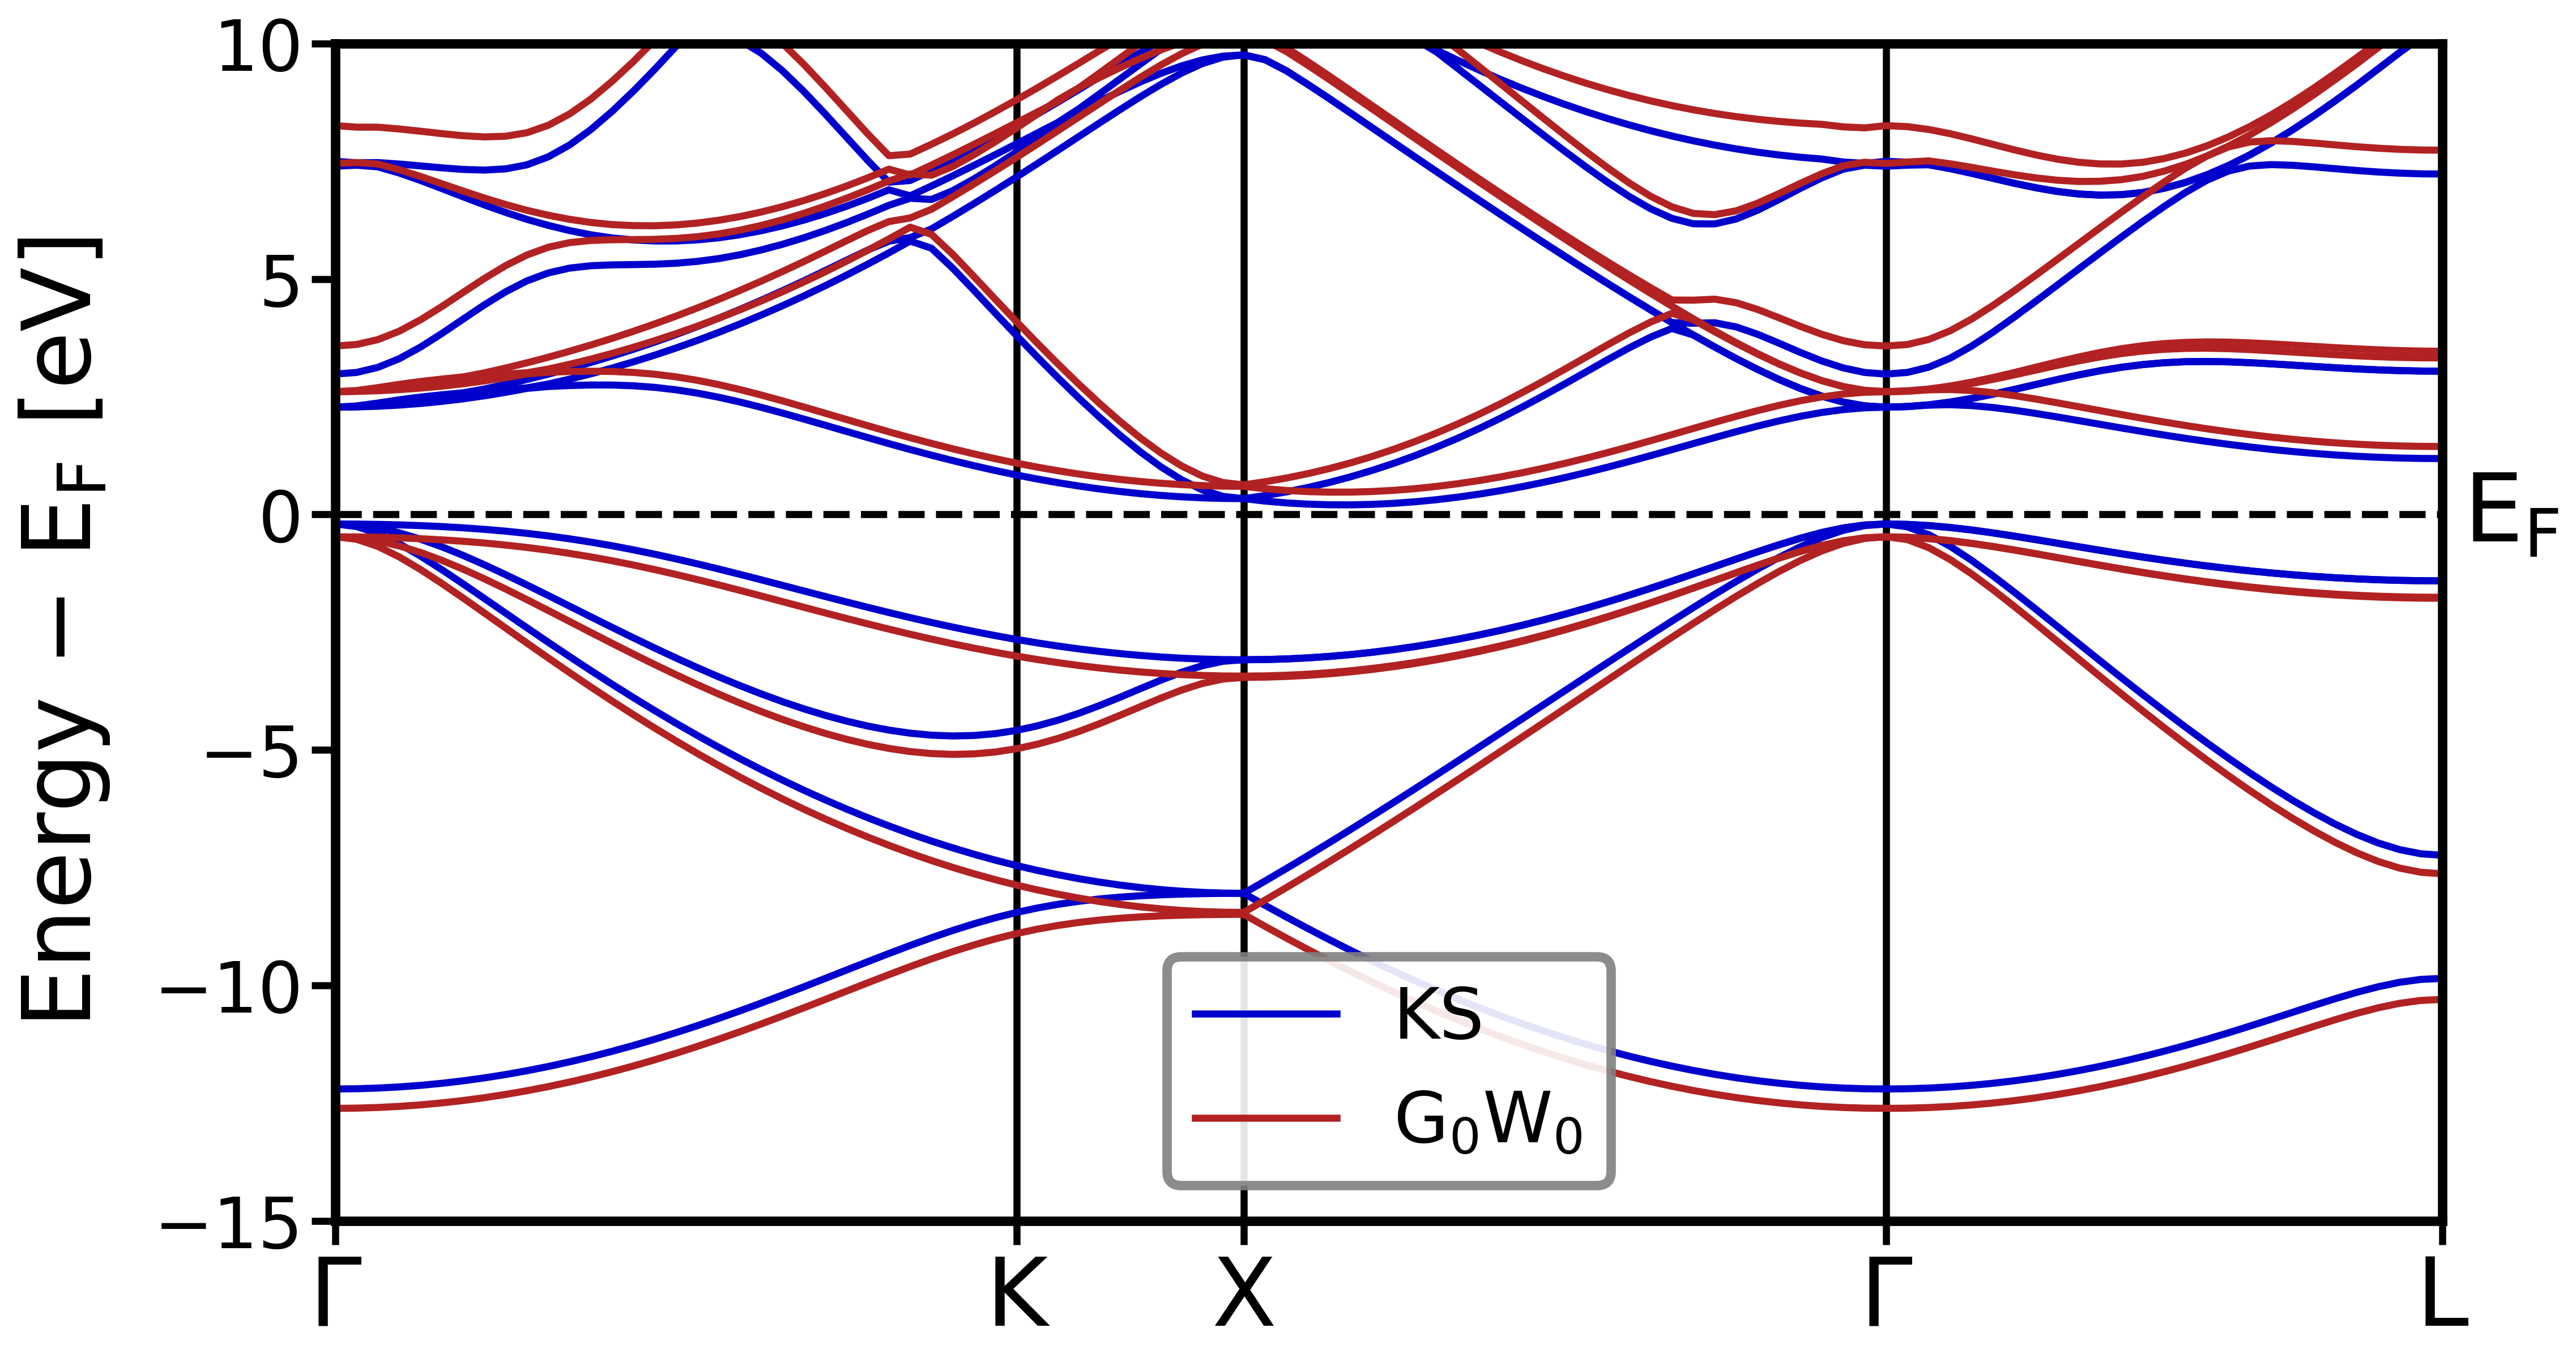" width="600" align="left"/>
</div>

An interesting result is obtained if the **KS** and **G<sub>0</sub>W<sub>0</sub>** electronic band structures are compared by setting the energy zero at the valence band maximum (**VBM**):

In [22]:
%%bash
cd run_Si_GW
python3 -m excitingscripts.plot.band_structure -a KS GW  -e -15 10 -z vbM
cd ..

The result should look like the following.

<div>
<img src=" 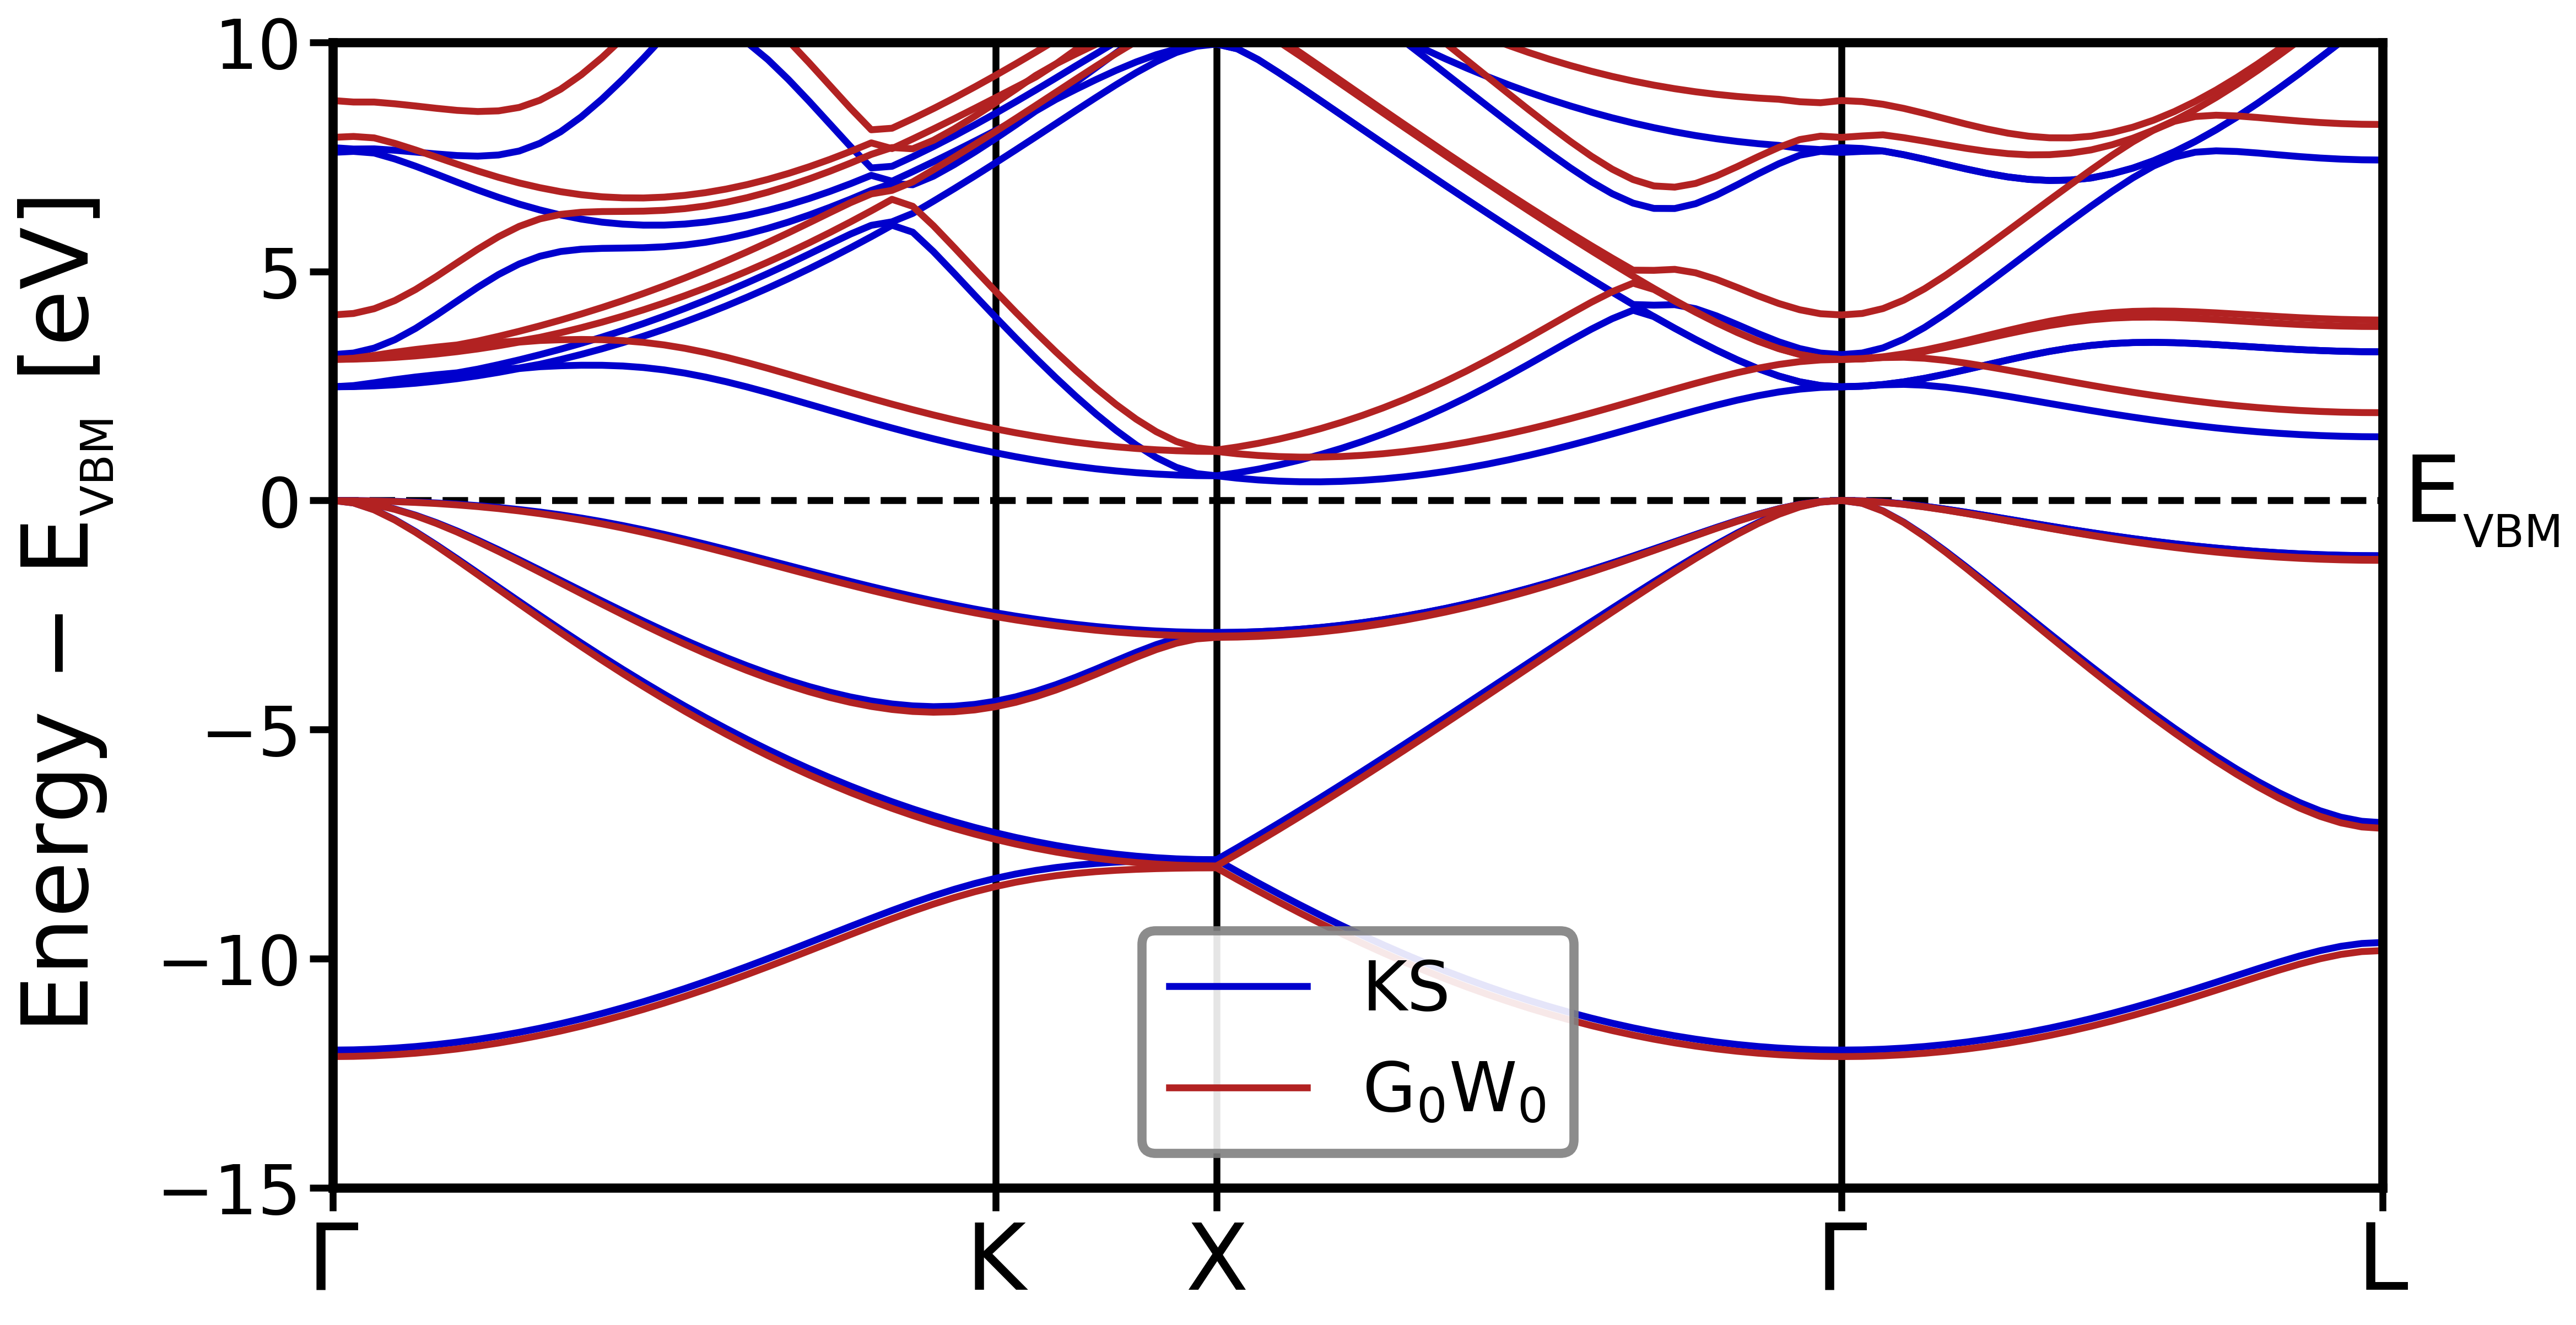" width="600" align="left"/>
</div>

This plot shows that the main difference between the two band structures is due to the conduction bands which seem to be uniformly shifted upwards by a constant value. This is the theoretical justification of the so-called **<span style="color:firebrick">scissor</span>** approximation.

<a id='5'></a>
**ii) Density of States**

Now, we will compute and compare the Kohn-Sham (**KS**) and quasiparticle (**QP, G<sub>0</sub>W<sub>0</sub>**) density of states. To calculate them, one should introduce the following changes into the **input.xml** file.

* In the <code><span style="color:green">gw</span></code> element replace <code><span style="color:mediumblue">taskname</span>=<span style="color:firebrick">"band"</span></code> by <code><span style="color:mediumblue">taskname</span>=<span style="color:firebrick">"dos"</span></code> to calculate the **QP** density of states on the basis of results obtained from the previous **G<sub>0</sub>W<sub>0</sub>** run.
```xml
...
   <gw
      taskname="dos"
      ... >
   </gw>
...
```

In [23]:
# The following lines modify the input.xml using Python

parsed_input = ExcitingInputXML.from_xml('./run_Si_GW/input.xml')

parsed_input.gw.taskname = "dos"

parsed_input.write('./run_Si_GW/input.xml')

In [24]:
%%bash
cd run_Si_GW
time $EXCITINGROOT/bin/exciting_smp input.xml
cd ..

 ### Using specified input file: input.xml
 ### Using specified input file: input.xml
 
Info(bandstr):
 band structure plot written to BAND.OUT
 
 Fermi energy is at zero in plot
 
 Vertex location lines written to BANDLINES.OUT
 
 ### Using specified input file: input.xml
 
Info(dos):
 
   Total density of states written to TDOS.OUT
 
   Fermi energy is at zero in plot
 
   DOS units are states/Hartree/unit cell
 
 ### Using specified input file: input.xml


   Elapsed time = 0m2s


The results for the **KS** and **G<sub>0</sub>W<sub>0</sub>** density of states are stored in **TDOS.OUT** and **TDOS-QP.OUT** correspondingly. To visualize them one can simply execute the script **`excitingscripts.plot.dos`** (discussed in [**The python script "plot.dos"**](https://www.exciting-code.org/the-python-script-plot.dos)).

In [26]:
%%bash
cd run_Si_GW
python3 -m excitingscripts.plot.dos -a KS GW
cd ..

The script produces a file **PLOT.png** which you can visualize on the screen with standard tools. The result should look like the following.

<figure>
<img src=" 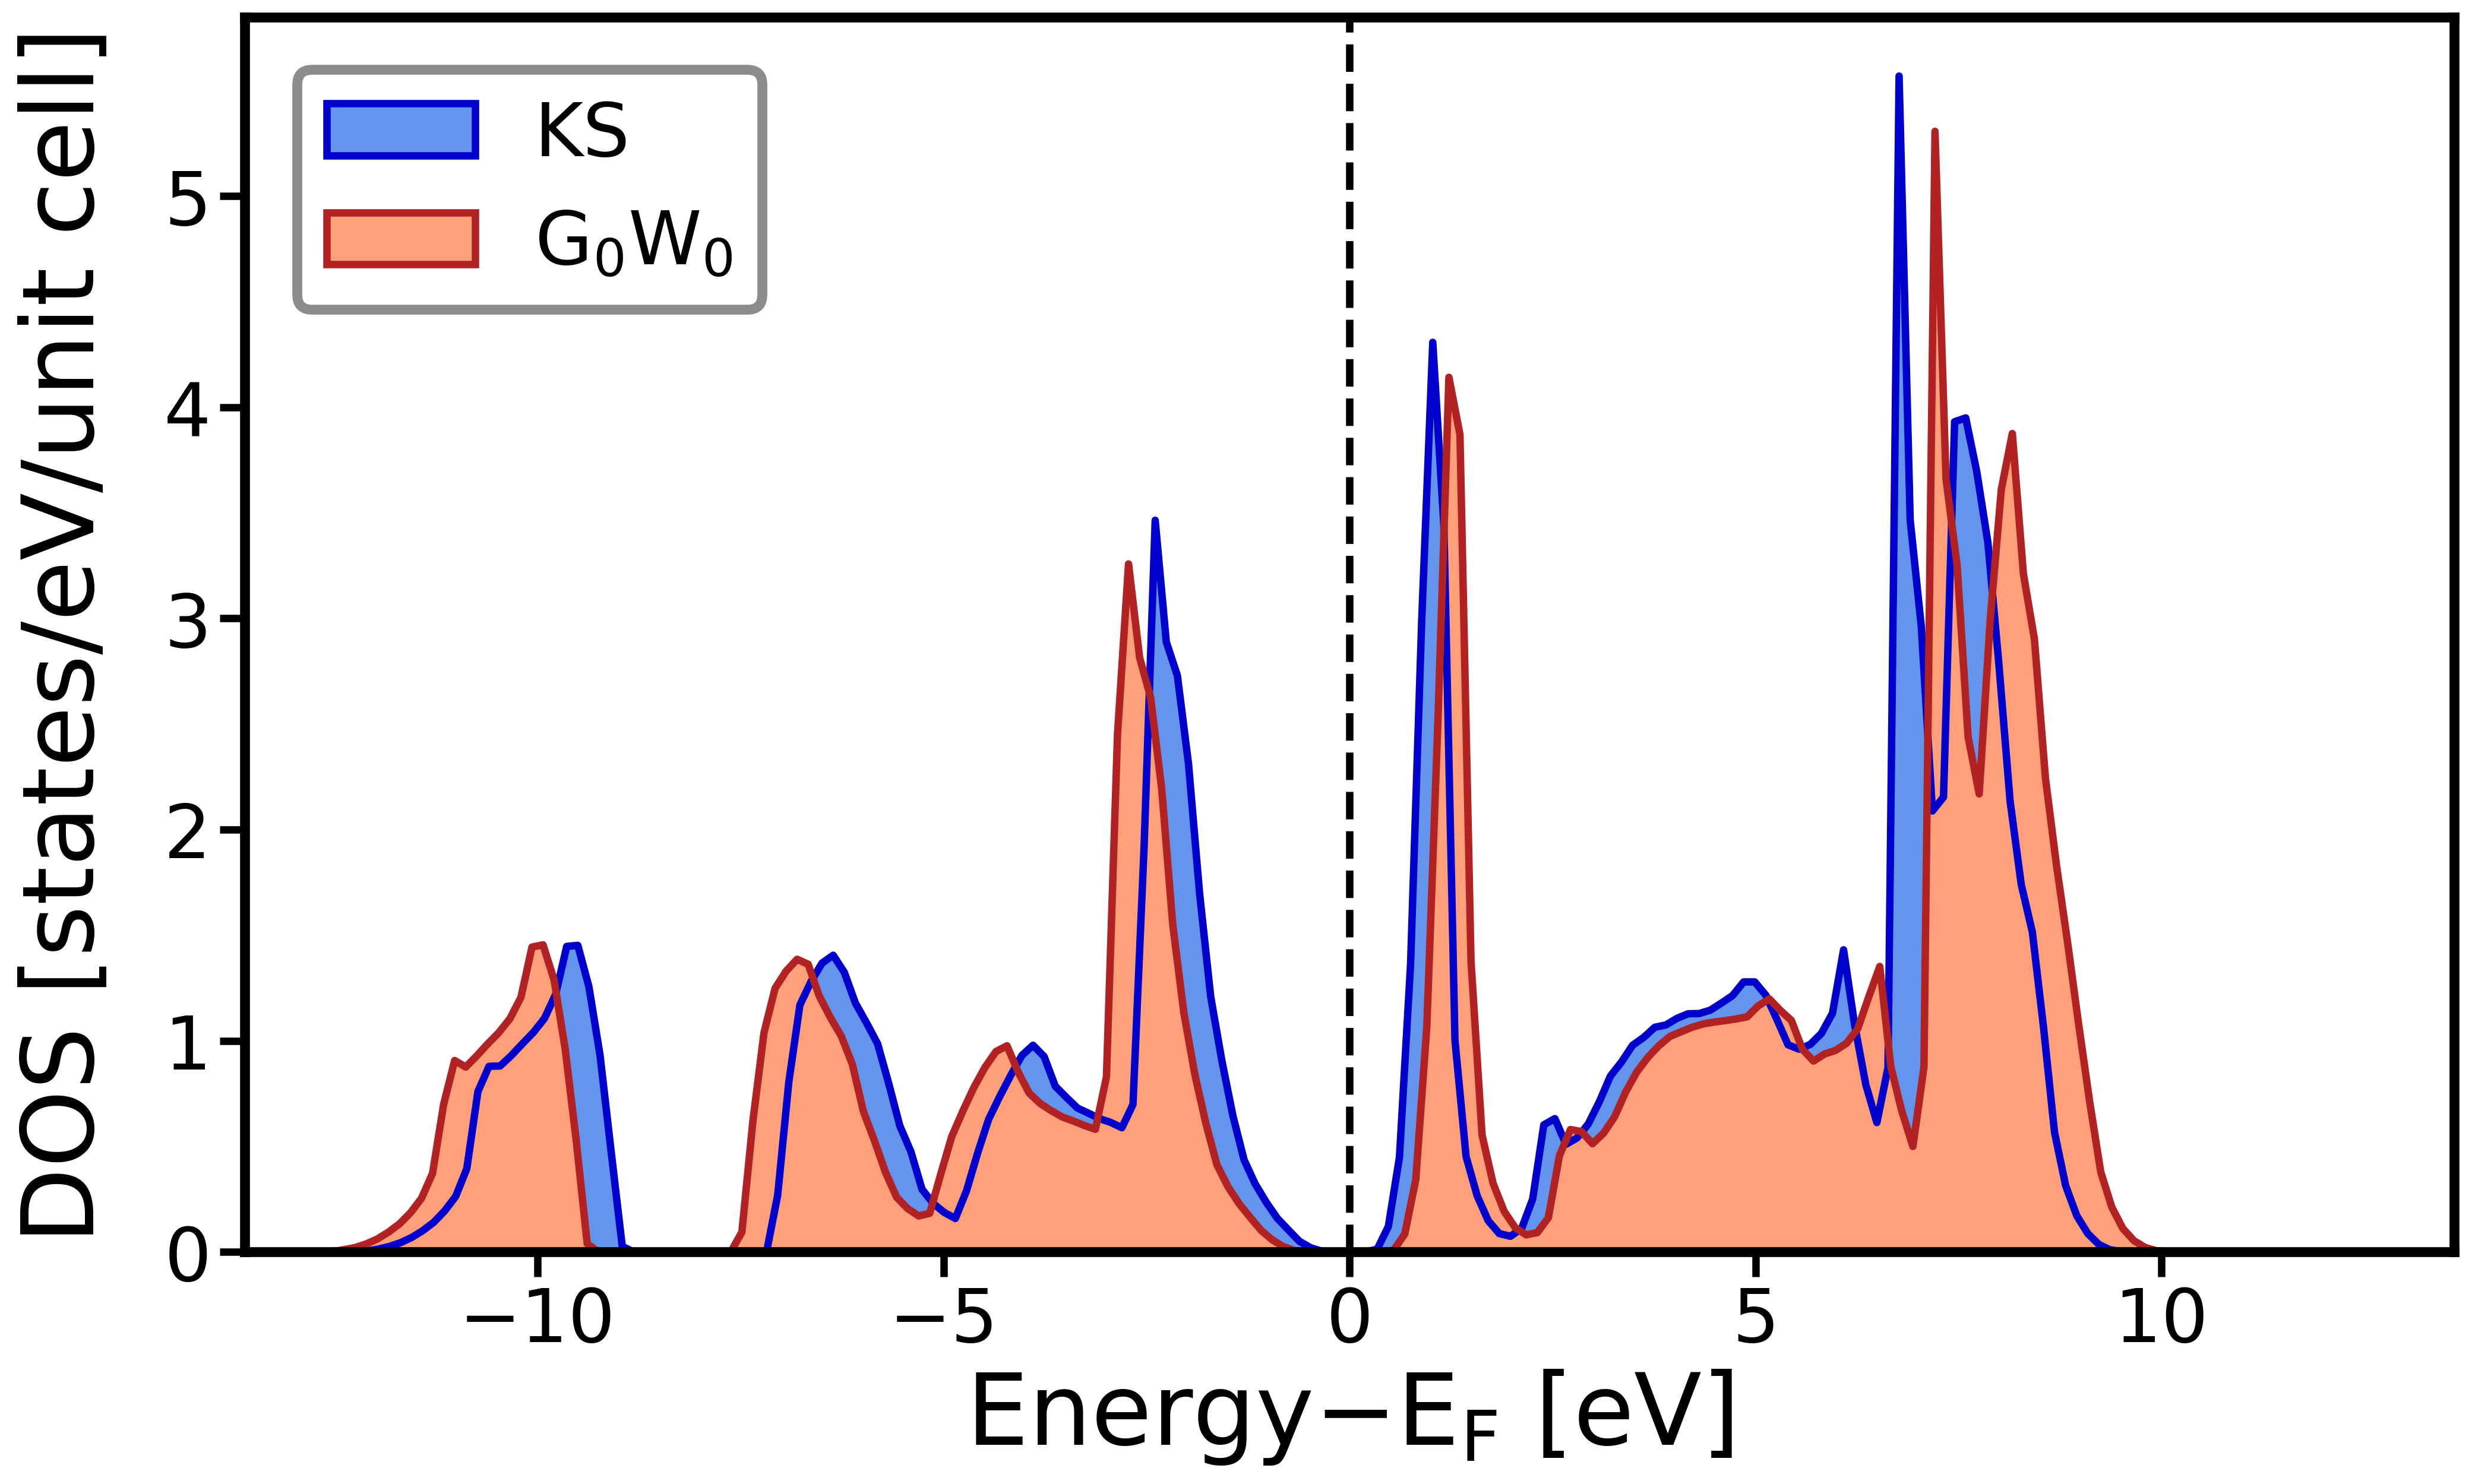" width="600" align="left"/>
</figure>

<a id='6'></a>
**<span style="color:green">Converging Results</span>**

The quasiparticle energies obtained from **G<sub>0</sub>W<sub>0</sub>** depend on many parameters (some of them in a crucial way). In order to keep the runtimes of the above calculations short, certain parameters were reduced from their converged values. The most important parameters are

Parameter | Description | Info
:--- | :--- | :---
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">ngridq</span></code> | **k**-mesh | very crucial and should always be converged
<code><span style="color:green">gw</span></code>/<code><span style="color:mediumblue">nempty</span></code> | number of unoccupied states | very crucial and sometimes difficult to converge

In the general case, additional attention should be payed to the proper choice of the system-dependent parameters used in the <code><span style="color:green">mixbasis</span></code>, <code><span style="color:green">freqgrid</span></code>, *etc.*, subelements of <code><span style="color:green">gw</span></code> to obtain physically relevant results (see **[Input Reference](https://www.exciting-code.org/home/about/input-reference)**).

<a id='5'></a>
**<span style="color:green">Exercise </span>**

- Once you have successfully run the previous **GW** calculation, you can play around with computational parameters in order to achieve the desired convergence for the value of the electronic band gap.
    1. Try to perform a convergence test with respect to the size of the **k** and **q**-meshs that appear in the both the <code><span style="color:green">groundstate</span></code> and the <code><span style="color:green">gw</span></code> elements.
    2. Try to run a similar test for the number of empty states. Be careful when increasing this parameter, since the calculation might quickly become very time-consuming.
    

- Repeat the complete **GW** calculation for a different system, *e.g.*, diamond or boron nitride.

<a id='7'></a>
<hr style="border:1px solid #DDD"> </hr>

### <span style="color:#15317E">Literature</span>

- <a id='6'><span style="color:firebrick">**Hybertsen1986**</span></a>: M. S. Hybertsen and S. G. Louie, Phys. Rev. B **34**, 5390 (1986).
- <a id='7'><span style="color:firebrick">**Hedin1965**</span></a>: L. Hedin, Phys. Rev. **139**, A796 (1965).
- Tutorial talk [<span style="color:firebrick">**PDF**</span>](https://www.exciting-code.org/uploads/how-exciting/gw-exciting.pdf) at the **<span style="color:firebrick">HoW exciting! 2016</span>** workshop in Berlin .
- More details on the implementation of the **GW** formalism within the **LAPW** method: H. Jiang, R. I. Gomez-Abal, X. Li, C. Meisenbichler, C. Ambrosch-Draxl, and M. Scheffler, "*FHI-gap: A GW code Based on Augmented Planewaves*", Comp. Phys. Commun. **184**, 348 (2013).
- The converged **G<sub>0</sub>W<sub>0</sub>** results for Si and other materials, obtained with **exciting**, can be found in D. Nabok, A. Gulans, and C. Draxl, "*Accurate all-electron **G<sub>0</sub>W<sub>0</sub>** quasiparticle energies employing the full-potential augmented plane-wave method*", Phys. Rev. B **94**, 035118 (2016).


<hr style="border:2px solid #DDD"> </hr>